C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32428 (\N{CJK UNIFIED IDEOGRAPH-7EAC}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22522 (\N{CJK UNIFIED IDEOGRAPH-57FA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20110 (\N{CJK UNIFIED IDEOGRAPH-4E8E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170:

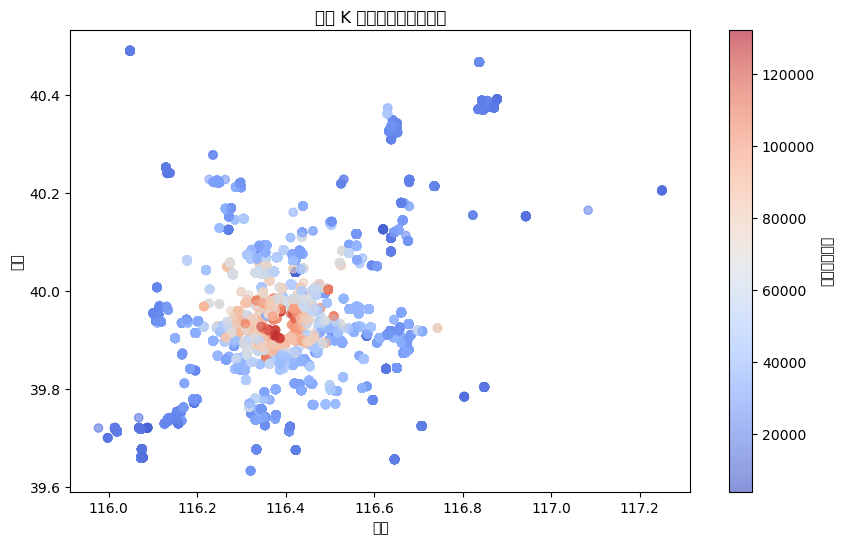

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

def compute_location_score(file_path, k=5):
    df = pd.read_csv(file_path, encoding='utf-8')

    if '价格' not in df.columns or '建筑面积' not in df.columns:
        raise ValueError("CSV 文件中未找到 '价格' 或 '建筑面积' 列")
    
    # 计算单价
    df["单价"] = df["价格"] / df["建筑面积"]
    
    # 选取经纬度作为地理特征
    locations = df[['lon', 'lat']].values

    # 使用 K 近邻算法计算最近邻房价均值
    knn = NearestNeighbors(n_neighbors=k, algorithm='ball_tree')
    knn.fit(locations)
    
    # 找到每个点的 K 个最近邻
    distances, indices = knn.kneighbors(locations)

    # 计算 K 近邻的平均单价作为地理位置评分
    location_scores = []
    for idx_list in indices:
        neighbor_prices = df.iloc[idx_list]["单价"].values
        location_scores.append(np.mean(neighbor_prices))
    
    df["地理位置评分"] = location_scores
    df.to_csv("output_0.csv", index=False, encoding='gbk')
    return df

# 使用该函数
df_with_location_score = compute_location_score("output_0.csv")

# 画出位置评分的分布
plt.figure(figsize=(10, 6))
plt.scatter(df_with_location_score["lon"], df_with_location_score["lat"], c=df_with_location_score["地理位置评分"], cmap="coolwarm", alpha=0.6)
plt.colorbar(label="地理位置评分")
plt.title("基于 K 近邻的地理位置评分")
plt.xlabel("经度")
plt.ylabel("纬度")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

# 计算地理位置评分并保存到训练集
def compute_location_score(file_path, min_k=5, max_k=15, output_file=None):
    df = pd.read_csv(file_path, encoding='utf-8')

    if '价格' not in df.columns or '建筑面积' not in df.columns:
        raise ValueError("CSV 文件中未找到 '价格' 或 '建筑面积' 列")
    
    # 计算单价
    df["单价"] = df["价格"] / df["建筑面积"]
    
    # 选取经纬度作为地理特征
    locations = df[['lon', 'lat']].values
    
    # 标准化经纬度数据
    scaler = StandardScaler()
    locations_scaled = scaler.fit_transform(locations)
    
    # 计算每个点的最近邻数（自适应）
    knn = NearestNeighbors(n_neighbors=max_k, algorithm='ball_tree')
    knn.fit(locations_scaled)  # 使用标准化后的经纬度进行 KNN 训练
    distances, indices = knn.kneighbors(locations_scaled)
    
    location_scores = []
    
    for i, idx_list in enumerate(indices):
        # 获取当前点的邻居的距离
        current_distances = distances[i]
        current_indices = idx_list
        
        # 进行距离排序
        sorted_distances = np.sort(current_distances)
        
        # 使用排序后的邻居距离来判断有效邻居数
        valid_neighbors = [current_indices[j] for j in
        range(len(sorted_distances)) if j == 0
        or sorted_distances[j] <= 3 * sorted_distances[j - 1]]
        
        # 确保有效邻居数在 min_k 和 max_k 之间
        k_neighbors = max(min_k, min(len(valid_neighbors), max_k))
        
        # 选择有效邻居并计算均价
        selected_indices = valid_neighbors[:k_neighbors]
        neighbor_prices = df.iloc[selected_indices]["单价"].values
        location_scores.append(np.mean(neighbor_prices))
    
    df["地理位置评分"] = location_scores
    print(location_scores[:10])  # 打印前10个地理位置评分

    # 保存训练集数据（包括地理位置评分）
    output_path = output_file if output_file else file_path
    df.to_csv(output_path, index=False, encoding='utf-8')
    print(f"地理位置评分已保存到 {output_path}")
    
    return df, scaler



# 运行训练集地理位置评分计算
train_df, scaler = compute_location_score("一次分类数据/output_6.csv", min_k=5, max_k=15)




[8149.248148101444, 11743.266574668893, 12628.2196952559, 9022.149069013989, 12628.2196952559, 7804.488845118952, 12283.468950788294, 12283.468950788294, 12837.263819779933, 12283.468950788294]
地理位置评分已保存到 一次分类数据/output_6.csv


In [ ]:
# 为测试集计算地理位置评分
def compute_location_score_for_test(test_file, train_df, scaler, min_k=5, max_k=15, output_file=None):
    test_df = pd.read_csv(test_file, encoding='utf-8')
    
    # 确保测试集包含经纬度数据
    if 'lon' not in test_df.columns or 'lat' not in test_df.columns:
        raise ValueError("CSV 文件中未找到 'lon' 或 'lat' 列")
    
    # 选取测试集的经纬度
    test_locations = test_df[['lon', 'lat']].values
    
    # 标准化测试集经纬度，使用 **训练集的标准化模型**
    test_locations_scaled = scaler.transform(test_locations)
    
    # 获取训练集经纬度和地理位置评分
    train_locations = train_df[['lon', 'lat']].values
    train_locations_scaled = scaler.transform(train_locations) 
    train_location_scores = train_df['地理位置评分'].values
    
    # 使用 KNN 查找每个测试集点的最近邻
    knn = NearestNeighbors(n_neighbors=max_k, algorithm='ball_tree')
    knn.fit(train_locations_scaled) 
    distances, indices = knn.kneighbors(test_locations_scaled)
    
    location_scores = []
    
    for i, idx_list in enumerate(indices):
        # 根据最近邻索引选择训练集中的地理位置评分
        neighbor_scores = train_location_scores[idx_list]
        location_scores.append(np.mean(neighbor_scores))
    
    # 赋值回测试集
    test_df["地理位置评分"] = location_scores
    print(location_scores[:10])  # 打印前10个地理位置评分

    # 保存测试集结果
    output_path = output_file if output_file else test_file
    test_df.to_csv(output_path, index=False, encoding='utf-8')
    print(f"测试集地理位置评分已保存到 {output_path}")
    
    return test_df

# 运行测试集地理位置评分计算
compute_location_score_for_test("一次测试数据/output_6test.csv", train_df, scaler, min_k=5, max_k=15)

[15833.116938543415, 15946.343301256209, 10887.232071331042, 5959.079370113587, 7549.2531635249625, 18460.626852499474, 11743.266574668894, 14036.319730475898, 9286.67378756065, 9192.974989246515]
测试集地理位置评分已保存到 一次测试数据/output_6test.csv


,ID,城市,区域,板块,环线,小区名称,建筑面积,套内面积,房屋朝向,建筑结构,...,卫,层高,层型,医院,学校,商场,公园,梯户比,交易时间差（天）,地理位置评分
0,13091,6,93,250,二至三环,中航华府,78.32,NaN,南,钢混结构,...,1,中,高层,0,0,0,0,0.40,527,15833.116939
1,13092,6,93,776,NaN,红枫林,110.62,85.80,南 北,钢混结构,...,1,高,高层,0,0,0,0,0.50,1847,15946.343301
2,13093,6,66,498,二至三环,浐灞半岛A6区,79.80,66.75,南,钢混结构,...,1,中,中层,0,0,0,0,0.25,1657,10887.232071
3,13094,6,6,64,NaN,群星莱骊三期,98.54,NaN,南 北,钢混结构,...,1,中,高层,1,0,0,1,0.25,1251,5959.079370
4,13095,6,71,801,NaN,含光苑,128.74,NaN,南 北,混合结构,...,2,中,中层,0,0,0,0,0.50,4905,7549.253164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1690,14781,6,71,244,NaN,横巷市委家属院南区,65.78,NaN,南 北,混合结构,...,1,中,中层,1,0,0,0,NaN,1910,8204.784481
1691,14782,6,91,723,NaN,润天小区,138.01,NaN,南 北,砖混结构,...,2,高,低层,0,0,0,0,NaN,-1,4898.534117
1692,14783,6,83,380,三环外,御湖蓝湾,110.00,NaN,南 北,未知结构,...,2,中,高层,0,0,0,0,NaN,-1,12089.981721
1693,14784,6,83,380,三环外,御湖蓝湾,136.00,NaN,南 北,未知结构,...,2,高,中层,0,0,0,0,NaN,-1,12089.981721
